<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio NLP + Sist. Recomendación


En este laboratorio, tabrajaras con datos de reseñas de productos para construir un sistema de recomendación que utilice procesamiento de lenguaje natural (NLP) y *machine learning*. El objetivo principal es que analices el contenido textual de las reseñas, clasifiques las opiniones en categorías (positiva, negativa o neutra) y aproveches esta información para personalizar las recomendaciones. El sistema priorizará los productos con mejores reseñas para usuarios específicos y permitirá evaluar si el análisis de sentimientos mejora la calidad de las recomendaciones. Tareas propuestas:


**Caso 1: Crear un sistema de recomendación**: Debes generar un sistema de recomendación para priorizar productos con las reseñas para cada usuario. Los pasos que deberás seguir son:    

- Estructurar el conjunto de datos

- Sistema basado en contenido


**Caso 2: Clasificar reseñas en positivas, negativas o neutras** Deberás implementar un modelo para analizar las reseñas textuales y clasificarlas en tres categorías:

- Positivas: Si el sentimiento de la reseña es favorable.

- Negativas: Si el sentimiento de la reseña es desfavorable.

- Neutras: Si la reseña no tiene un sentimiento claro.
	
- Pasos :
	- Preprocesamiento de texto: Limpiar las reseñas eliminando caracteres especiales, palabras vacías (stopwords) y realizar lematización.
	
	- Identificar las reseñas positivas, negativas y neutrales. 


Los datos los tendréis en el [siguiente enlace](https://drive.google.com/drive/u/0/folders/1vK5zESy9KElRhm_utg_lHHXuUArrwWgu) con la descipción de cada una de las columnas.  

---

### Caso 1

In [2]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import math
import re

# Visualizaciones
# -----------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Para modelos NLP
# -----------------------------------------------------------------------
import spacy
from nltk.corpus import stopwords
import nltk
import contractions
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, classification_report

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix

# Configuración de pandas
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None)

# Otros
# -----------------------------------------------------------------------
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity

/opt/homebrew/Caskroom/miniconda/base/envs/proyecto7/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('data/datos.csv', index_col=0).reset_index(drop=True)

In [4]:
df.head()

,reviewId,reviewDate,mainDepartment,subDepartment,productName,reviewTitle,reviewStar,reviewText,inconsistentStatus
0,RXDM4W1ZL7L4L,"Reviewed in the United States on June 22, 2021",Sports and Outdoors,Outdoor Recreation,Doctor Developed Copper Wrist Brace / Carpal T...,One size does not fit all.,3.0,Nice lightweight brace but unfortunately was t...,1
1,R2GINAKQJOSWEL,"Reviewed in the United States on August 27, 2021",Computers,Men's Clothing,Fruit of the Loom Men's Coolzone Boxer Briefs,They were ok but thats it,4.0,Boxers were ok. The color did start to fade pr...,0
2,RD5R7T2JNP104,"Reviewed in the United States on May 21, 2021",Computers,Networking Products,"TP-Link AC750 WiFi Extender (RE220), Covers Up...",Good if you need a little extra.,4.0,Very easy to install. Worked right away but it...,0
3,R3UEHJJ17E730C,"Reviewed in the United States on March 7, 2021",Home and Kitchen,Bath,"Gorilla Grip Luxury Chenille Bathroom Rug Mat,...",Color wrong!!!,1.0,The color is completely different than hunter ...,1
4,R2257OUFMQ8P5C,"Reviewed in the United States on October 17, 2020",Beauty and Personal Care,Hair Care,WOW Apple Cider Vinegar Shampoo and Hair Condi...,I have 4A hair,2.0,"From reading the reviews, I was hoping that th...",0


In [5]:
def limpiar_columna(text, nlp, stop_words):
    text = contractions.fix(text)  # Convierte "don't" -> "do not"
        
    # Limpieza de texto
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar puntuación
    text = re.sub(r'\d+', '', text)  # Eliminar números
    text = re.sub(r'\s+', ' ', text)  # Reemplazar múltiples espacios o saltos de línea por un espacio
    text = text.strip()  # Quitar espacios en blanco al inicio y al final
    doc = nlp(text)  # Tokenizar con spaCy

    # eliminamos las stop words
    tokens = [token.lemma_ for token in doc if token.text not in stop_words]
    return tokens

Veamos si hay nombres de productos duplicados

In [6]:
df['productName'].duplicated().sum()

np.int64(9901)

Vamos a crear un ID único por cada producto. Para ello crearemos un diccionario con ID y nombres (únicos)

In [7]:
dc = dict(enumerate(df['productName'].unique()))

Como queremos reemplazar el nombre con el ID necesitamos intercambiar las claves y los valores

In [8]:
dc_reversed = {v : k for k, v in dc.items()}

Aplicamos el diccionario

In [9]:
df['productID'] = df['productName'].replace(dc_reversed)

/var/folders/gf/rtshnkx974q994djpf858hv40000gn/T/ipykernel_45423/4201456733.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['productID'] = df['productName'].replace(dc_reversed)


### Sistema basado en contenido

Para crear un sistema de recomendación basado en contenido vamos a ver qué columnas pueden proporcionarnos información útil.

In [10]:
df.columns

Index(['reviewId', 'reviewDate', 'mainDepartment', 'subDepartment',
       'productName', 'reviewTitle', 'reviewStar', 'reviewText',
       'inconsistentStatus', 'productID'],
      dtype='object')

Posiblemente `productName` sea la columna que contiene información más relevante para crear un sistema de recomendación basada en contenido. Aunque también podríamos considerar `mainDepartment` o `subDepartment`

Vamos a limpiar y tokenizar el nombre de producto

In [11]:
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words("english"))

In [12]:
df['productNameLimpio'] = df['productName'].apply(lambda x: " ".join(limpiar_columna(x, nlp, stop_words)))

Vamos a utilizar un Tf-idf vectorizer para procesar el texto

In [13]:
vectorizer = TfidfVectorizer(max_features=1000)

df_vect = pd.DataFrame(vectorizer.fit_transform(df["productNameLimpio"].unique()).toarray(), 
                       columns = vectorizer.get_feature_names_out())

In [14]:
df_vect.shape

(99, 874)

In [15]:
df.shape

(10000, 11)

In [16]:
df['productID'].nunique()

99

Vamos a llevarnos los ID de los productos al índice del dataframe

In [17]:
df_vect["productID"] = df["productID"].unique()
df_vect = df_vect.set_index("productID")

Construimos la matriz de similaridad

In [18]:
df_similarity = pd.DataFrame(cosine_similarity(df_vect))

Ahora elegimos el número de recomendaciones que queremos y el id del producto del que queremos 

In [72]:
numero_recomendaciones = 10
product_id = 33

In [73]:
print("Recomendaciones en base a:", dc[product_id])
similarities = df_similarity[product_id].rename("similarity").sort_values(ascending=False).iloc[1:].reset_index()
similarities["product"] = similarities["index"].replace(dc)
similarities.drop(columns='index').head(numero_recomendaciones)

Recomendaciones en base a: ComfyBrace Posture Corrector-Back Brace for Men and Women- Fully Adjustable Straightener for Mid, Upper Spine Support- Neck, Shoulder, Clavicle and Back Pain Relief-Breathable


,similarity,product
0,0.188502,Doctor Developed Copper Wrist Brace / Carpal T...
1,0.088770,"(Refurbished) Apple iPhone 7, 32GB, Black - Fu..."
2,0.058871,Amazon Basics Ergonomic Office Desk Chair with...
3,0.055275,Vera Wang Princess Eau de Toilette Spray for W...
4,0.054225,SoftSheen-Carson Magic Razorless Shaving for M...
5,0.054091,Goorin Bros. Men's Animal Farm Snap Back Truck...
6,0.047933,"Android 10.0 Tablet : MEBERRY 10"" Ultra-Fast 4..."
7,0.044422,Beckham Hotel Collection Bed Pillows for Sleep...
8,0.043267,Nautica Voyage By Nautica For Men Eau De Toile...
9,0.040023,"livho 2 Pack Blue Light Blocking Glasses, Comp..."


### También podemos construir un sistema de recomendación basado en contenido utilizando las reviews

In [87]:
df['reviewText'].head()

0    Nice lightweight brace but unfortunately was t...
1    Boxers were ok. The color did start to fade pr...
2    Very easy to install. Worked right away but it...
3    The color is completely different than hunter ...
4    From reading the reviews, I was hoping that th...
Name: reviewText, dtype: object

Veamos si tenemos un número suficiente de valores no nulos.

In [88]:
df["reviewText"].isna().sum()

np.int64(1)

Como solamente tenemos uno podemos eliminarlo directamente

In [89]:
df.dropna(subset="reviewText", inplace=True)

Vamos a utilizar un sistema de embeddings ya que al utilizar las reviews necesitamos que se tenga en cuenta el contexto y la posición de las palabras.

Vamos a agrupar los datos por `productID` agregando el texto de las reviews

In [91]:
df_reviews = df.groupby("productID")["reviewText"].sum()

Utilizamos el modelo Bert

In [92]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

Función para crear los embeddings

In [94]:
def get_embedding(texts):

    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings

In [100]:
embeddings = get_embedding(list(df_reviews))
df_embeddings = pd.DataFrame(embeddings)
df_embeddings.index = df_reviews.index

Cada columna es un embedding y las filas representan cada producto

In [105]:
df_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
productID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.175943,-0.125623,0.407718,0.042663,0.351508,0.016937,0.102535,0.457759,0.057035,-0.353777,0.228519,-0.356220,-0.124390,0.147437,-0.366783,0.397377,0.393118,-0.091560,-0.417580,0.499690,0.536078,-0.185861,0.101358,0.584309,0.238842,0.033870,0.058199,0.025

Construimos la matriz de similaridad de embeddings utilizando la similaridad coseno

In [ ]:
df_similarity_embeddings = pd.DataFrame(cosine_similarity(df_embeddings), columns = df_embeddings.index, index = df_embeddings.index)

In [108]:
df_similarity_embeddings.head()

productID,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98
productID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.000000,0.932935,0.913343,0.912515,0.920713,0.933115,0.910045,0.917942,0.922256,0.932412,0.935873,0.928366,0.917734,0.938210,0.947273,0.920750,0.934384,0.942111,0.934459,0.932133,0.915621,0.923973,0.950658,0.916942,0.919876,0.926445,0.917140,0.945787,0.946303,0.929896,0.931884,0.944730,0.898869,0.959378,0.942560,0.941914,0.951834,0.912965,0.914356,0.935429,0.912201,0.907519,0.921286,0.922866,0.641030,0.942048,0.899933,0.947312,0.939768,0.945938,0.922943,0.943349,0.915937,0.925406,0.905489,0.920108,0.922412,0.920297,0.946777,0.908056,0.912070,0.926097,0.934581,0.917532,0.945100,0.926782,0.899241,0.943223,0.948150,0.925781,0.937904,0.933374,0.931036,0.932890,0.900051,0.850121,0.934394,0.957637,0.907442,0.917852,0.920279,0.944468,0.907641,0.925307,0.910403,0.944256,0.921805,0.936748,0.953615,0.905125,0.942811,0.853565,0.936555,0.795941,0.715301,0.896144,0.635257,0.731493,0.900641
1,0.932935,1.000000,0.880926,0.908331,0.910622,0.924434,0.889474,0.914721,0.913524,0.936494,0.908364,0.921186,0.896092,0.930088,0.925473,0.945633,0.933365,0.920220,0.937129,0.911129,0.887657,0.933358,0.919953,0.895800,0.922785,0.918875,0.897680,0.938712,0.921704,0.914501,0.924501,0.943669,0.885406,0.936323,0.925834,0.930778,0.928508,0.892095,0.894582,0.907384,0.865385,0.911478,0.908281,0.887396,0.669443,0.930559,0.887118,0.949568,0.965881,0.945675,0.899553,0.920669,0.913470,0.906097,0.921003,0.903348,0.909141,0.901979,0.936584,0.886086,0.890467,0.919996,0.928369,0.951522,0.954010,0.932912,0.879868,0.963996,0.928432,0.918403,0.931631,0.905527,0.939273,0.966157,0.880566,0.825337,0.917981,0.951398,0.878602,0.877447,0.893857,0.951430,0.888821,0.907702,0.893899,0.921935,0.909113,0.932189,0.937593,0.904734,0.921594,0.829436,0.906614,0.806455,0.769643,0.871038,0.677162,0.773669,0.877748
2,0.913343,0.880926,1.000000,0.901705,0.886947,0.937253,0.944211,0.901394,0.887785,0.898234,0.939462,0.906451,0.952294,0.902761,0.944707,0.888490,0.918304,0.941409,0.890082,0.896868,0.956025,0.902270,0.898551,0.953015,0.907097,0.927712,0.956412,0.904329,0.913072,0.949403,0.944142,0.913169,0.929348,0.908260,0.909417,0.927669,0.917790,0.933518,0.945916,0.947899,0.938233,0.899063,0.890431,0.934195,0.704929,0.938309,0.913539,0.911151,0.897808,0.909905,0.955142,0.934373,0.929790,0.966810,0.897534,0.897890,0.895064,0.930899,0.918208,0.947082,0.944463,0.902319,0.943959,0.887229,0.895606,0.910063,0.939148,0.885595,0.923230,0.908175,0.940135,0.924586,0.896688,0.885055,0.923517,0.922043,0.884134,0.895164,0.965104,0.946875,0.955870,0.890272,0.948124,0.903610,0.904148,0.922034,0.921151,0.921736,0.911907,0.890709,0.911410,0.930143,0.933551,0.833893,0.707584,0.940072,0.682748,0.695269,0.942102
3,0.912515,0.908331,0.901705,1.000000,0.925879,0.913666,0.916606,0.919132,0.934362,0.916333,0.911465,0.923622,0.917745,0.932188,0.930359,0.947199,0.933515,0.922184,0.923666,0.903955,0.899491,0.940653,0.918071,0.896145,0.917975,0.912897,0.903854,0.942733,0.947821,0.928645,0.930881,0.948842,0.928030,0.921907,0.931102,0.942004,0.924451,0.925551,0.909494,0.915814,0.910320,0.919008,0.917350,0.914092,0.653450,0.927636,0.936626,0.910963,0.924745,0.932581,0.919739,0.928616,0.899594,0.916177,0.927350,0.924130,0.936099,0.928873,0.937864,0.920098,0.913444,0.943446,0.914979,0.921795,0.926991,0.937244,0.920495,0.915604,0.933647,0.945305,0.916982,0.935817,0.931693,0.910469,0.933183,0.844830,0.926108,0.930446,0.918771,0.902656,0.883013,0.917614,0.925024,0.922373,0.950909,0.926680,0.939800,0.952564,0.947258,0.903010,0.923012,0.883852,0.931702,0.806087,0.715375,0.919084,0.634649,0.708072,0.936447
4,0.920713,0.910622,0.

Al igual que antes construimos el sistema de recomendación en función del producto inicial y el número de recomendaciones que queramos.

In [ ]:
numero_recomendaciones = 10
product_id = 33

In [116]:
print("Recomendaciones en base a:", dc[product_id])
similarities = df_similarity_embeddings[product_id].rename("similarity").sort_values(ascending=False).iloc[1:].reset_index()
similarities["productID"] = similarities["productID"].replace(dc)
similarities.head(numero_recomendaciones)

Recomendaciones en base a: ComfyBrace Posture Corrector-Back Brace for Men and Women- Fully Adjustable Straightener for Mid, Upper Spine Support- Neck, Shoulder, Clavicle and Back Pain Relief-Breathable


,productID,similarity
0,Doctor Developed Copper Wrist Brace / Carpal T...,0.959378
1,Fit Simplify Resistance Loop Exercise Bands wi...,0.956916
2,Amazon Basics Extra Thick Exercise Yoga Gym Fl...,0.956510
3,New Balance Men's 623 V3 Casual Comfort Cross ...,0.953445
4,"Coleman Cooler Quad Portable Camping Chair, Blue",0.951590
5,Avarelle Acne Pimple Patch (40 Count) Absorbin...,0.950056
6,Fitbit Charge 4 Fitness and Activity Tracker w...,0.947494
7,Hard As Hoof Nail Strengthening Cream with Coc...,0.946879
8,"NYX PROFESSIONAL MAKEUP Epic Ink Liner, Waterp...",0.946462
9,Amazon Basics Ergonomic Office Desk Chair with...,0.946035


Vemos que en el caso de utilizar las reviews con embeddings la similaridad es mucho mayor, lo cual tiene sentido ya que el contexto de las reviews en ocasiones puede ser similar y este método es capaz de captarlo adecuadamente.

### Caso 2

Reejecutamos nlp y stop_words (por si nos saltamos la celda donde estaba hecho)

In [118]:
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words("english"))

In [119]:
sia = SentimentIntensityAnalyzer()

Tokenizamos el texto de la reviews

In [123]:
df["reviewTextTokenizado"] = df["reviewText"].apply(lambda x : " ".join(limpiar_columna(x, nlp, stop_words)))

In [124]:
df["reviewTextTokenizado"]

0       nice lightweight brace unfortunately large wri...
1       boxer ok color start fade pretty quickly becom...
2       easy install work right away go far expectedit...
3       color completely different hunter green andor ...
4       read review hope shampoo conditioner would ext...
                              ...                        
9995    scale great food prep fast responsive go sleep...
9996              comfortable little small ride heel size
9997    really great volleyball water problem amazon w...
9998                            good fit comfortable wear
9999    great pillow way plush somewhat firm extremely...
Name: reviewTextTokenizado, Length: 9999, dtype: object

Aplicamos el polarity scores al texto tokenizado

In [125]:
def sentimiento(text):

    sia = SentimentIntensityAnalyzer()
    return sia.polarity_scores(text)

df['resultados'] = df['reviewTextTokenizado'].apply(sentimiento)

In [128]:
df[df['resultados'].apply(pd.Series).columns] = df['resultados'].apply(pd.Series)

Vamos a seleccionar las columnas que nos resulten interesantes

In [130]:
df_sent = df[['productID', 'reviewStar', 'reviewText', 'reviewTextTokenizado', 'inconsistentStatus', 'neg', 'neu', 'pos', 'compound']]

In [131]:
df_sent

,productID,reviewStar,reviewText,reviewTextTokenizado,inconsistentStatus,neg,neu,pos,compound
0,0,3.0,Nice lightweight brace but unfortunately was t...,nice lightweight brace unfortunately large wri...,1,0.121,0.603,0.276,0.4767
1,1,4.0,Boxers were ok. The color did start to fade pr...,boxer ok color start fade pretty quickly becom...,0,0.138,0.539,0.323,0.4767
2,2,4.0,Very easy to install. Worked right away but it...,easy install work right away go far expectedit...,0,0.000,0.523,0.477,0.8020
3,3,1.0,The color is completely different than hunter ...,color completely different hunter green andor ...,1,0.000,1.000,0.000,0.0000
4,4,2.0,"From reading the reviews, I was hoping that th...",read review hope shampoo conditioner would ext...,0,0.000,0.541,0.459,0.8979
...,...,...,...,...,...,...,...,...,...
9995,17,5.0,This scale is great for food prep. It is fast ...,scale great food prep fast responsive go sleep...,0,0.000,0.403,0.597,0.9501
9996,48,3.0,Comfortable but a little small. Rides down on...,comfortable little small ride heel size,1,0.000,0.602,0.398,0.5106
9997,55,4.0,Really great volleyball for the water!! Only p...,really great volleyball water problem amazon w...,0,0.226,0.419,0.355,0.4754
9998,1,4.0,Good fit and comfortable to wear.,good fit comfortable wear,0,0.000,0.103,0.897,0.8271


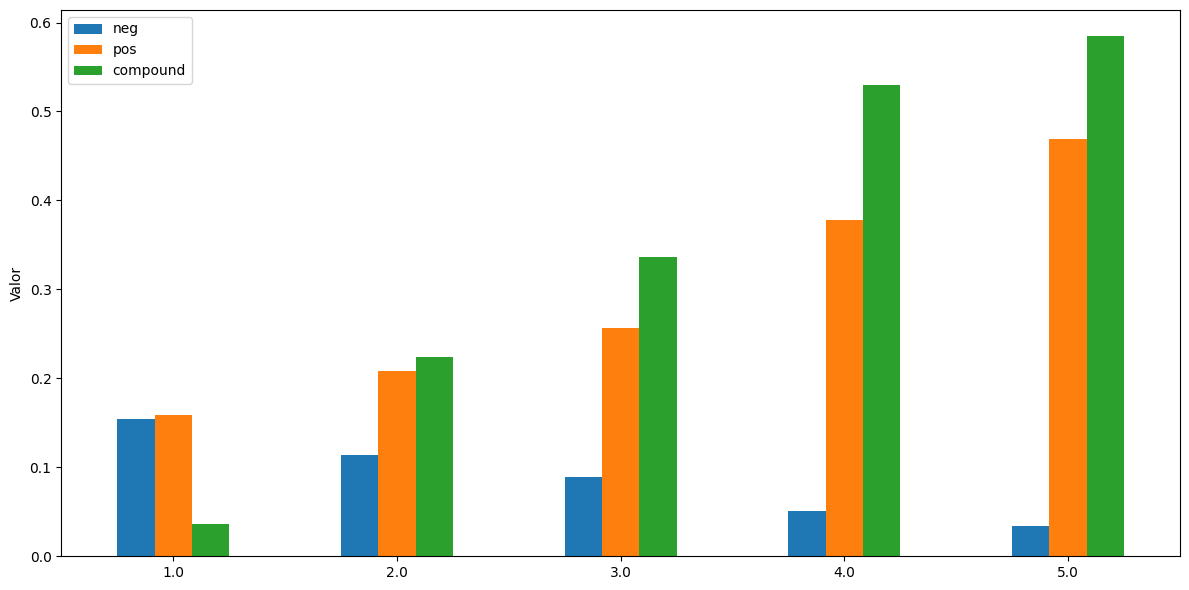

In [133]:
df_group = df_sent.groupby('reviewStar')[['neg', 'pos', 'neu', 'compound']].mean()

ax = df_group.drop(columns='neu').plot(kind='bar', stacked=False, figsize=(12, 6))

plt.xlabel('')
plt.ylabel('Valor')
plt.xticks(rotation=0)
plt.legend(title='')
plt.tight_layout()
plt.show()

Vemos que los productos con más estrellas tienen un valor de compound y de positive mucho mayores que los que tienen menos estrellas, mientras que en negative ocurre al contrario. 